# Analysis of Winds at Mount Everest's South Col

## Introduction 

< Detail to follow here >

In [11]:
# Import relevant modules
%matplotlib inline
import pandas as pd, datetime, numpy as np, matplotlib.pyplot as plt

# Functions
def RHO(p,tv):
    
    """
    Computes the air density
    
    Inputs/Outputs (units: explanation): 
    
    In:
        - p (Pa)        : air pressure
        - tv (K or C)   : virtual temperature (can be approximated as T if air is
                          very dry -- low specific humidity)
        
    Out:
    
        - rho (kg/m^3) : air density
        
    """ 
    _rd=287.053 # Gas constant for dry air
    _tv=tv*1.
    if np.nanmax(_tv)<100: _tv +=273.15# NB: C-->K
    if np.nanmax(p)<2000: p*=100 # hPa to Pa
    rho=np.divide(p,np.multiply(_rd,_tv))

    return rho

def CRIT_U(p,tv):
    
    """
    Computes the wind speed required to yield a force of 72 N
    on the "average" man. 
    
    Inputs/Outputs (units: explanation): 
    
    In:
        - p (Pa)       : air pressure
        - tv (K or C)  : virtual temperature (can be approximated as T if air is
                         very dry -- low specific humidity)
        
    Out:
    
        - uc (m/s)     : wind speed to produce force of 72N
        
    """    
    rho=RHO(p,tv)
    # Note: 144 = 2x 72 N; 0.3 = 0.6 drag coef * surface area 0.5 m**2
    uc=np.power(np.divide(144,np.multiply(rho,0.3)),0.5)
    
    return uc

In [12]:
# Declare files and other parameters
thresh=1 # Filter out hourly-mean winds < this value
nroll=24*30 # Number of items to include in moving averages

# Manual inspection suggests dubious data quality during this period
st=datetime.datetime(year=2019,month=12,day=27,hour=17)
stp=datetime.datetime(year=2020,month=1,day=2,hour=6)

# Should limit all data to this period
stp_gl=datetime.datetime(year=2020,month=1,day=5,hour=11)

# Load

# Ditto observations -- incl. filtering and alocation
date_parser=lambda x: pd.datetime.strptime(x,'%d/%m/%Y %H:%M')
di="C:/Users/gytm3/OneDrive - Loughborough University/Everest/Publications/Weather/Data/"
fin="/home/lunet/gytm3/Everest2019/AWS/Logging/south_col.csv"
#data=pd.read_csv(fin,parse_dates=["TIMESTAMP"],date_parser=date_parser,index_col=0)
data=pd.read_csv(fin,parse_dates=True,index_col=0)
for i in data.columns: data[i]=data[i].astype(np.float)
data=data.loc[data.index<=stp_gl]

In [13]:
## Extraction of vars
# Select wind pairing we want (from second sensor)
u=data["WS_AVG_2"]
ug=data["WS_MAX_2"]
idx=np.logical_and(u>thresh,ug>thresh) # very minimal filter that removes wind during v. slack conditions
idx=np.logical_and(idx,~np.logical_and(u.index>=st,u.index<=stp))
print("Keeping %.1f%% of data"%((np.sum(idx)/np.float(len(idx)))*100))
u.values[~idx]=np.nan
ug.values[~idx]=np.nan

# Air pressure
p=data["PRESS"]
# Air temperature
t=data["T_HMP"]
# Experiment -- force pressure to be mslp (comment out to remove)
# ------------------------------------------------
# p=pd.Series(np.ones(len(p))*1013.,index=p.index)
# t=pd.Series(np.ones(len(t))*288.,index=t.index)
# ------------------------------------------------

Keeping 91.3% of data


In [14]:
## Computations 
# critical wind
uc=CRIT_U(p,t)
print("1st and 99th percentiles of uc = %.1f & %.1f m/s, respectively" %(np.nanpercentile(uc,1),np.nanpercentile(uc,99)))
print("Min and Max of uc = %.1f & %.1f m/s, respectively" %(np.nanmin(uc),np.nanmax(uc)))
print("Mean uc = %.1f"%np.nanmean(uc))
# binary series - above / below critical
du=(u>=uc)*1.
dug=(ug>=uc)*1.
du_r=(u>=20)*1.# ref : s/l threshold
dug_r=(ug>=20)*1. # ref : s/l threshold

1st and 99th percentiles of uc = 29.8 & 30.9 m/s, respectively
Min and Max of uc = 29.7 & 31.2 m/s, respectively
Mean uc = 30.4


In [24]:
## Processing

# Need number of non-nans
nvalid=np.float(np.sum(idx))
# stats
nmu=np.sum(du) # nmean above
fmu=np.sum(nmu)/nvalid*100. # as %
ng=np.sum(dug) # ngust above
fg=np.sum(ng)/nvalid*100. # as %
# repeat for reference
nmu_r=np.sum(du_r) # nmean above
fmu_r=np.sum(nmu_r)/nvalid*100. # as %
ng_r=np.sum(dug_r) # ngust above
fg_r=np.sum(ng_r)/nvalid*100. # as %

# output
print("Hours above (mean): %.0f (%.3f%%)"%(nmu,fmu))
print("Hours above (gust): %.0f (%.3f%%)"%(ng,fg))
print("...Hours above [20 m/s] (mean): %.0f (%.3f%%)"%(nmu_r,fmu_r))
print("...Hours above [20 m/s] (gust): %.0f (%.3f%%)"%(ng_r,fg_r))

# Rolling stats
denom=pd.Series(idx*1.,index=ug.index)
denom=denom.rolling(nroll,center=True).sum()
# Running sum of dangerous gusts
dgrun=dug.rolling(nroll,center=True).sum()/denom*100.
# output time of max
print("running %.0f day max ug prob peaked on:"%((nroll/24.)),dgrun.loc[dgrun==np.nanmax(dgrun)].index)


# What was the max wind and force experienced?
_rho=RHO(p,t)
F=1/2.*_rho*ug**2*0.5*0.6
print("Max wind gust = %.1f m/s, and max force = %.1f N"%(np.nanmax(ug),np.nanmax(F)))
Ff=9.81*60; print("Force from gravity = %.2f N" % (Ff))
print(_rho)

Hours above (mean): 4 (0.080%)
Hours above (gust): 965 (19.300%)
...Hours above [20 m/s] (mean): 538 (10.760%)
...Hours above [20 m/s] (gust): 2016 (40.320%)
('running 30 day max ug prob peaked on:', DatetimeIndex(['2019-12-11 12:00:00', '2019-12-11 13:00:00',
               '2019-12-11 14:00:00', '2019-12-11 15:00:00',
               '2019-12-11 16:00:00', '2019-12-11 17:00:00',
               '2019-12-11 18:00:00', '2019-12-11 19:00:00',
               '2019-12-11 20:00:00'],
              dtype='datetime64[ns]', freq=None))
Max wind gust = 66.2 m/s, and max force = 348.4 N
Force from gravity = 588.60 N
2019-05-22 06:00:00    0.519537
2019-05-22 07:00:00    0.519582
2019-05-22 08:00:00    0.518726
2019-05-22 09:00:00    0.517745
2019-05-22 10:00:00    0.519326
2019-05-22 11:00:00    0.520954
2019-05-22 12:00:00    0.520886
2019-05-22 13:00:00    0.524476
2019-05-22 14:00:00    0.525688
2019-05-22 15:00:00    0.523707
2019-05-22 16:00:00    0.521948
2019-05-22 17:00:00    0.521073
201

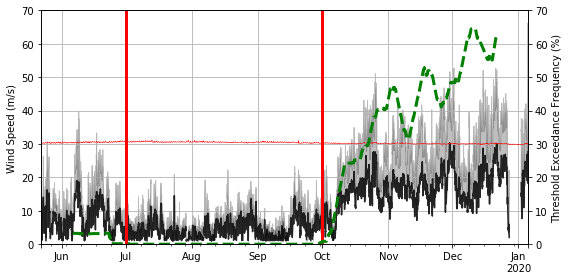

In [18]:
## Plotting
fig,ax=plt.subplots(1,1)
fig.set_size_inches(8,4)
ax2=ax.twinx()
u.plot(ax=ax,alpha=0.8,color='k')
ax.fill_between(u.index,u.values[:],ug.values[:],color='k',alpha=0.25)
#ax.scatter(ug.index,ug.values[:],color='k',s=1,alpha=0.25)
uc.plot(ax=ax,linewidth=0.5,color='red')
dgrun.plot(ax=ax2,linestyle="--",color='green',linewidth=3)
ax.grid()
ax.set_ylim([0,70])
ax2.set_ylim([0,70])
ax.set_ylabel("Wind Speed (m/s)")
ax.set_xlabel("")
ax2.set_ylabel("Threshold Exceedance Frequency (%)")
ax.axvline(datetime.datetime(year=2019,month=7,day=1),color='red',linewidth=3)
ax.axvline(datetime.datetime(year=2019,month=10,day=1),color='red',linewidth=3)
plt.tight_layout()
fig.savefig("AWS_wind.png",dpi=600)
